<a href="https://colab.research.google.com/github/ThomasWong-ST/Intro-to-RL/blob/main/IntroRL_K_ArmedBandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
# from bandit_env import KArmedBandit # Removed: Class defined in notebook cell
# from agent import EpsilonGreedyAgent # Removed: Class defined in notebook cell
import matplotlib.pyplot as plt

In [2]:
class KArmedBandit:
    def __init__(self, k=10, mean=0.0, std=1.0, seed=0):
        """
        k arms; each arm a has a (fixed) reward distribution ~ N(q*_a, 1).
        q*_a are drawn once at init from N(mean, std^2).
        """
        rng = np.random.default_rng(seed)
        self.k = k
        self.q_star = rng.normal(loc=mean, scale=std, size=k)
        self.rng = rng

    def step(self, action: int) -> float:
        """
        Input: action a in {0,...,k-1}
        Output: reward ~ N(q*_a, 1)
        """
        if action in range(self.k):
          reward = self.rng.normal(loc = self.q_star[action], scale = 1)
          return reward
        else:
          raise ValueError("Action not in range")

    def optimal_action(self) -> int:
        """Return argmax_a q*_a (for evaluation only)."""
        return int(np.argmax(self.q_star))

In [50]:
beta = KArmedBandit(k=10, mean=0.0, std=1.0, seed=0).step(7)
print(beta)

0.32380650059189


In [7]:
class EpsilonGreedyAgent:
    def __init__(self, k, epsilon=0.1, alpha=None, seed=1):
        """
        Q estimates start at 0.
        If alpha is None, use sample-average updates; else constant step-size alpha.
        """
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = np.zeros(k, dtype=float)
        self.N = np.zeros(k, dtype=int)   # action counts for sample-average
        self.rng = np.random.default_rng(seed)

    def select_action(self) -> int:
        """
        With prob ε: explore (uniform random arm).
        With prob 1-ε: exploit (argmax Q).
        Tie-breaks: choose uniformly among maxima.
        """

        best_actions = np.flatnonzero(self.Q == self.Q.max())
        if self.rng.random() < self.epsilon:
            return self.rng.integers(self.k)
        else:
            return int(self.rng.choice(best_actions))


    def update(self, a: int, r: float):
        """
        Sample-average: Q[a] <- Q[a] + (1/N[a]) * (r - Q[a])
        Constant step:  Q[a] <- Q[a] + alpha * (r - Q[a])
        """

        if self.alpha is None:
            self.N[a] += 1
            self.Q[a] += (1/self.N[a]) * (r - self.Q[a])
        else:
            self.Q[a] += self.alpha * (r - self.Q[a])

In [51]:
a = EpsilonGreedyAgent(k=10).select_action()
print(a)

7


q_star: [ 0.30471708 -1.03998411  0.7504512   0.94056472 -1.95103519 -1.30217951
  0.1278404  -0.31624259 -0.01680116 -0.85304393]
best-mean = 0.9405647163912139
Final Q: [ 0.27545646 -1.04483583  0.49869411  0.91552193 -1.71317138 -0.95374175
 -0.16809416 -0.51303606  0.13852687 -0.91626471]
Best action: 3
Optimal arm index: 3
Times chosen: 867


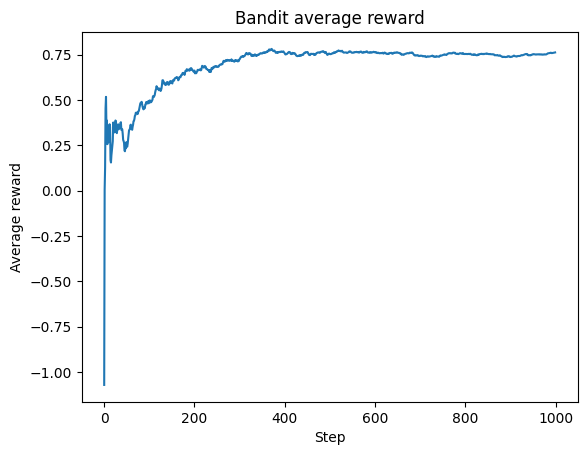

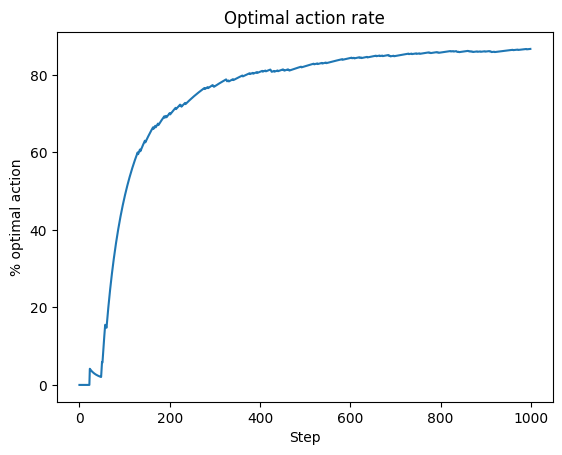

In [13]:
def run(k=10, steps=1000, epsilon=0.1, alpha=None, seed=42):
    env = KArmedBandit(k=k, seed=seed)
    agent = EpsilonGreedyAgent(k=k, epsilon=epsilon, alpha=alpha, seed=seed+1)

    rewards = np.zeros(steps)
    optimal = np.zeros(steps, dtype=bool)
    opt_action = env.optimal_action()

    print("q_star:", env.q_star)
    print("best-mean =", np.max(env.q_star))


    for t in range(steps):

        # 1) choose action
        a = agent.select_action()

        # 2) step env
        r = env.step(a)

        # 3) update agent
        agent.update(a, r)

        # 4) logging
        rewards[t] = r
        optimal[t] = (a == opt_action)

    print("Final Q:", agent.Q)
    print("Best action:", opt_action)
    print("Optimal arm index:", opt_action)
    print("Times chosen:", int(optimal.sum()))
    # quick plots
    plt.figure()
    plt.plot(np.cumsum(rewards) / (np.arange(steps) + 1))
    plt.xlabel("Step"); plt.ylabel("Average reward"); plt.title("Bandit average reward")
    plt.show()

    plt.figure()
    plt.plot(100 * np.cumsum(optimal) / (np.arange(steps) + 1))
    plt.xlabel("Step"); plt.ylabel("% optimal action"); plt.title("Optimal action rate")
    plt.show()

if __name__ == "__main__":
    run()

q_star: [ 0.30471708 -1.03998411  0.7504512   0.94056472 -1.95103519 -1.30217951
  0.1278404  -0.31624259 -0.01680116 -0.85304393]
best-mean = 0.9405647163912139
Final Q: [ 0.41097743 -0.98851826  0.1752209   0.57729644 -1.89668827 -1.37878463
 -0.15000563 -0.16845181 -0.17253513 -1.02379264]
Best action: 3
Optimal arm index: 3
Times chosen: 4198


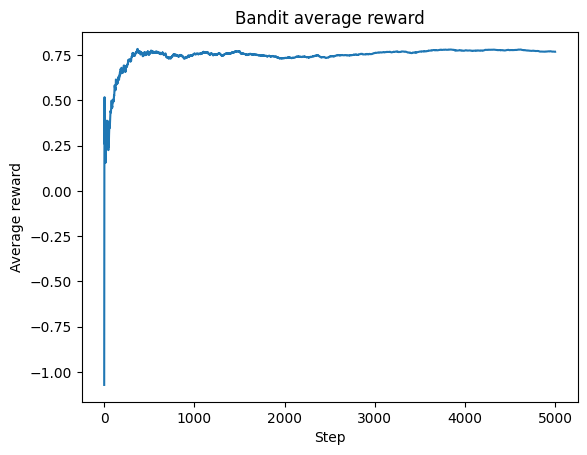

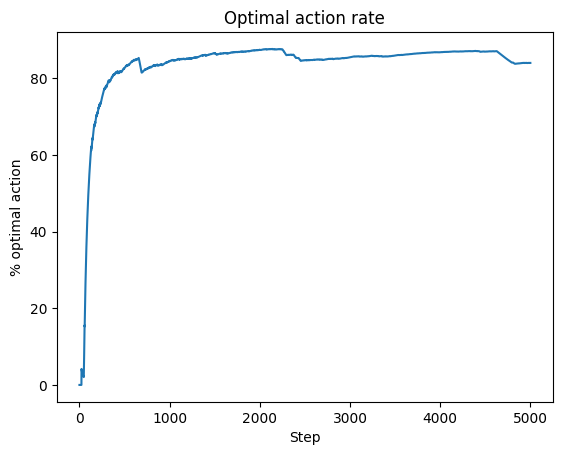

In [14]:
#Constant alpha, let alpha = 0.1, steps = 5000
run(steps =5000, alpha=0.1)